# Imports

In [1]:
N_threads = 6

In [2]:
%load_ext autoreload

import sys, os
os.environ["OMP_NUM_THREADS"] = str(N_threads)
os.environ["OPENBLAS_NUM_THREADS"] = str(N_threads)
os.environ["MKL_NUM_THREADS"] = str(N_threads)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(N_threads)
os.environ["NUMEXPR_NUM_THREADS"] = str(N_threads)

import numpy as np
import pickle

from sbi.utils.posterior_ensemble import NeuralPosteriorEnsemble

import SBIBE as sbibe

%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('default')
plt.close('all')

np.random.seed(seed=0)

2023-10-25 22:33:18.528860: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 22:33:18.528915: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 22:33:18.528937: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-25 22:33:18.538216: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-25 22:33:19.504536: W tensorflow/c

# Get posteriors from N best trained networks

In [3]:
path_wandb_sweep = "/dipc_storage/dlopez/Projects/sbibe/wandb_models"
N_best_combine = 2

In [4]:
sweep_names, losses = sbibe.sbi_wandb_utils.load_wandb_sweep_register(path_wandb_sweep)

<IPython.core.display.Javascript object>


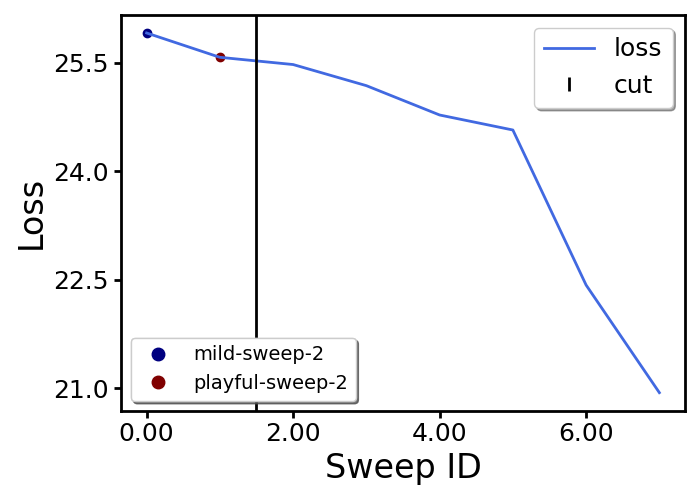

/tmp/ipykernel_390581/204117121.py:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([ii], losses[ii], c=colors[ii])


In [5]:
custom_lines = [
    mpl.lines.Line2D([0], [0], color='royalblue', ls='-', lw=2, marker=None, markersize=9),
    mpl.lines.Line2D([], [], color='k', marker='|', linestyle='None', markersize=10, markeredgewidth=2)
]    
fig, ax = sbibe.plot_utils.simple_plot(
    x_label=r'Sweep ID',
    y_label=r'Loss',
    custom_labels=[r'loss', r'cut'],
    custom_lines=custom_lines
)
ax.plot(losses, color='royalblue', lw=2)
ax.axvline(N_best_combine-0.5, color='k', lw=2)

custom_lines = []
custom_labels = []
colors = sbibe.plot_utils.get_N_colors(N_best_combine, mpl.colormaps['jet'])
for ii in range(N_best_combine):
    ax.scatter([ii], losses[ii], c=colors[ii])
    custom_lines.append(mpl.lines.Line2D([0], [0], color=colors[ii], ls='-', lw=0, marker='o', markersize=9))
    custom_labels.append(sweep_names[ii])
legend = ax.legend(custom_lines, custom_labels, loc='lower left',
                   fancybox=True, shadow=True, ncol=1,fontsize=14)
ax.add_artist(legend)

plt.tight_layout()
plt.show()

In [6]:
posteriors =  sbibe.sbi_wandb_utils.load_posteriors(path_wandb_sweep, sweep_names[:N_best_combine])
posterior = NeuralPosteriorEnsemble(posteriors=posteriors)

# Extract test - posterior inference - rank stats

In [7]:
# ------------------ extract test ------------------ #

dict_bounds_test = {
    'omega_cold'    :  [0.25, 0.38],
    'omega_baryon'  :  [0.042, 0.058],
    'hubble'        :  [0.62, 0.78],
    'ns'            :  [0.93, 1.00],
    'sigma8_cold'   :  [0.75, 0.88],
}
theta_test = sbibe.sbi_data_utils.sample_latin_hypercube(dict_bounds_test, 987)
xx_test, kk = sbibe.sbi_data_utils.get_xx(dict_bounds_test, theta_test)

# ------------------ posterior inference ------------------ #

# norm_xx_test = scaler.transform(xx_test)

inferred_theta_test = sbibe.sbi_utils.sample_posteriors_theta_test(
    posterior,
    xx_test,
    dict_bounds_test
)

# ------------------ rank stats ------------------ #

ranks = sbibe.sbi_utils.compute_ranks(theta_test, inferred_theta_test)

Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading linear emulator...


/lscratch/dlopez/programs/miniconda_20221210/miniconda3/envs/VE_SBIBE/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/lscratch/dlopez/programs/miniconda_20221210/miniconda3/envs/VE_SBIBE/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/lscratch/dlopez/programs/miniconda_20221210/miniconda3/envs/VE_SBIBE/lib/python3.11/site-packages/sklearn/base

Linear emulator loaded in memory.
Loading no-wiggles emulator...
No-wiggles emulator loaded in memory.
Loading non-linear emulator...


/lscratch/dlopez/programs/miniconda_20221210/miniconda3/envs/VE_SBIBE/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/lscratch/dlopez/programs/miniconda_20221210/miniconda3/envs/VE_SBIBE/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.22.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/lscratch/dlopez/programs/miniconda_20221210/miniconda3/envs/VE_SBIBE/lib/python3.11/site-packa

Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.


/lscratch/dlopez/programs/miniconda_20221210/miniconda3/envs/VE_SBIBE/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/lscratch/dlopez/programs/miniconda_20221210/miniconda3/envs/VE_SBIBE/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


0


Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 524 posterior samples:   0%|          | 0/524 [00:00<?, ?it/s]

Drawing 529 posterior samples:   0%|          | 0/529 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 532 posterior samples:   0%|          | 0/532 [00:00<?, ?it/s]

Drawing 468 posterior samples:   0%|          | 0/468 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 524 posterior samples:   0%|          | 0/524 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 524 posterior samples:   0%|          | 0/524 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

20


Drawing 535 posterior samples:   0%|          | 0/535 [00:00<?, ?it/s]

Drawing 465 posterior samples:   0%|          | 0/465 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 535 posterior samples:   0%|          | 0/535 [00:00<?, ?it/s]

Drawing 465 posterior samples:   0%|          | 0/465 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 526 posterior samples:   0%|          | 0/526 [00:00<?, ?it/s]

40


Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 457 posterior samples:   0%|          | 0/457 [00:00<?, ?it/s]

Drawing 543 posterior samples:   0%|          | 0/543 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

60


Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 530 posterior samples:   0%|          | 0/530 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

80


Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 525 posterior samples:   0%|          | 0/525 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 528 posterior samples:   0%|          | 0/528 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 527 posterior samples:   0%|          | 0/527 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 467 posterior samples:   0%|          | 0/467 [00:00<?, ?it/s]

Drawing 533 posterior samples:   0%|          | 0/533 [00:00<?, ?it/s]

100


Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 528 posterior samples:   0%|          | 0/528 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 529 posterior samples:   0%|          | 0/529 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

120


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 529 posterior samples:   0%|          | 0/529 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

140


Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 528 posterior samples:   0%|          | 0/528 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 524 posterior samples:   0%|          | 0/524 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 526 posterior samples:   0%|          | 0/526 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 531 posterior samples:   0%|          | 0/531 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

160


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 523 posterior samples:   0%|          | 0/523 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 526 posterior samples:   0%|          | 0/526 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 527 posterior samples:   0%|          | 0/527 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

180


Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 525 posterior samples:   0%|          | 0/525 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 531 posterior samples:   0%|          | 0/531 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 523 posterior samples:   0%|          | 0/523 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 525 posterior samples:   0%|          | 0/525 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 528 posterior samples:   0%|          | 0/528 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

200


Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 467 posterior samples:   0%|          | 0/467 [00:00<?, ?it/s]

Drawing 533 posterior samples:   0%|          | 0/533 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 464 posterior samples:   0%|          | 0/464 [00:00<?, ?it/s]

Drawing 536 posterior samples:   0%|          | 0/536 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 530 posterior samples:   0%|          | 0/530 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

220


Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 530 posterior samples:   0%|          | 0/530 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 529 posterior samples:   0%|          | 0/529 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 527 posterior samples:   0%|          | 0/527 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 539 posterior samples:   0%|          | 0/539 [00:00<?, ?it/s]

Drawing 461 posterior samples:   0%|          | 0/461 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 531 posterior samples:   0%|          | 0/531 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 542 posterior samples:   0%|          | 0/542 [00:00<?, ?it/s]

Drawing 458 posterior samples:   0%|          | 0/458 [00:00<?, ?it/s]

240


Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 525 posterior samples:   0%|          | 0/525 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 523 posterior samples:   0%|          | 0/523 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 525 posterior samples:   0%|          | 0/525 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 467 posterior samples:   0%|          | 0/467 [00:00<?, ?it/s]

Drawing 533 posterior samples:   0%|          | 0/533 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 529 posterior samples:   0%|          | 0/529 [00:00<?, ?it/s]

260


Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 525 posterior samples:   0%|          | 0/525 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 528 posterior samples:   0%|          | 0/528 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 457 posterior samples:   0%|          | 0/457 [00:00<?, ?it/s]

Drawing 543 posterior samples:   0%|          | 0/543 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 523 posterior samples:   0%|          | 0/523 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

280


Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 523 posterior samples:   0%|          | 0/523 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 534 posterior samples:   0%|          | 0/534 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 465 posterior samples:   0%|          | 0/465 [00:00<?, ?it/s]

Drawing 535 posterior samples:   0%|          | 0/535 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 540 posterior samples:   0%|          | 0/540 [00:00<?, ?it/s]

Drawing 460 posterior samples:   0%|          | 0/460 [00:00<?, ?it/s]

300


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 532 posterior samples:   0%|          | 0/532 [00:00<?, ?it/s]

Drawing 468 posterior samples:   0%|          | 0/468 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 467 posterior samples:   0%|          | 0/467 [00:00<?, ?it/s]

Drawing 533 posterior samples:   0%|          | 0/533 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 530 posterior samples:   0%|          | 0/530 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

320


Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 548 posterior samples:   0%|          | 0/548 [00:00<?, ?it/s]

Drawing 452 posterior samples:   0%|          | 0/452 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 524 posterior samples:   0%|          | 0/524 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 533 posterior samples:   0%|          | 0/533 [00:00<?, ?it/s]

Drawing 467 posterior samples:   0%|          | 0/467 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 458 posterior samples:   0%|          | 0/458 [00:00<?, ?it/s]

Drawing 542 posterior samples:   0%|          | 0/542 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

340


Drawing 538 posterior samples:   0%|          | 0/538 [00:00<?, ?it/s]

Drawing 462 posterior samples:   0%|          | 0/462 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 524 posterior samples:   0%|          | 0/524 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 529 posterior samples:   0%|          | 0/529 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 534 posterior samples:   0%|          | 0/534 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

360


Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 527 posterior samples:   0%|          | 0/527 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 524 posterior samples:   0%|          | 0/524 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

380


Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 525 posterior samples:   0%|          | 0/525 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 530 posterior samples:   0%|          | 0/530 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 525 posterior samples:   0%|          | 0/525 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

400


Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 523 posterior samples:   0%|          | 0/523 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 526 posterior samples:   0%|          | 0/526 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

420


Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 528 posterior samples:   0%|          | 0/528 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 523 posterior samples:   0%|          | 0/523 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 525 posterior samples:   0%|          | 0/525 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

440


Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 535 posterior samples:   0%|          | 0/535 [00:00<?, ?it/s]

Drawing 465 posterior samples:   0%|          | 0/465 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 524 posterior samples:   0%|          | 0/524 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 525 posterior samples:   0%|          | 0/525 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

460


Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 544 posterior samples:   0%|          | 0/544 [00:00<?, ?it/s]

Drawing 456 posterior samples:   0%|          | 0/456 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 526 posterior samples:   0%|          | 0/526 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

480


Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 531 posterior samples:   0%|          | 0/531 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 531 posterior samples:   0%|          | 0/531 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

500


Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 460 posterior samples:   0%|          | 0/460 [00:00<?, ?it/s]

Drawing 540 posterior samples:   0%|          | 0/540 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 527 posterior samples:   0%|          | 0/527 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 524 posterior samples:   0%|          | 0/524 [00:00<?, ?it/s]

520


Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 525 posterior samples:   0%|          | 0/525 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

540


Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 527 posterior samples:   0%|          | 0/527 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 524 posterior samples:   0%|          | 0/524 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 523 posterior samples:   0%|          | 0/523 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 529 posterior samples:   0%|          | 0/529 [00:00<?, ?it/s]

560


Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 528 posterior samples:   0%|          | 0/528 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 526 posterior samples:   0%|          | 0/526 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 527 posterior samples:   0%|          | 0/527 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

580


Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 468 posterior samples:   0%|          | 0/468 [00:00<?, ?it/s]

Drawing 532 posterior samples:   0%|          | 0/532 [00:00<?, ?it/s]

Drawing 467 posterior samples:   0%|          | 0/467 [00:00<?, ?it/s]

Drawing 533 posterior samples:   0%|          | 0/533 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

600


Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 534 posterior samples:   0%|          | 0/534 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 542 posterior samples:   0%|          | 0/542 [00:00<?, ?it/s]

Drawing 458 posterior samples:   0%|          | 0/458 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 529 posterior samples:   0%|          | 0/529 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 523 posterior samples:   0%|          | 0/523 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 523 posterior samples:   0%|          | 0/523 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 526 posterior samples:   0%|          | 0/526 [00:00<?, ?it/s]

Drawing 523 posterior samples:   0%|          | 0/523 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

620


Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 526 posterior samples:   0%|          | 0/526 [00:00<?, ?it/s]

Drawing 524 posterior samples:   0%|          | 0/524 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 531 posterior samples:   0%|          | 0/531 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 526 posterior samples:   0%|          | 0/526 [00:00<?, ?it/s]

640


Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 459 posterior samples:   0%|          | 0/459 [00:00<?, ?it/s]

Drawing 541 posterior samples:   0%|          | 0/541 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 529 posterior samples:   0%|          | 0/529 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 464 posterior samples:   0%|          | 0/464 [00:00<?, ?it/s]

Drawing 536 posterior samples:   0%|          | 0/536 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 528 posterior samples:   0%|          | 0/528 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

660


Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 523 posterior samples:   0%|          | 0/523 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

680


Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 467 posterior samples:   0%|          | 0/467 [00:00<?, ?it/s]

Drawing 533 posterior samples:   0%|          | 0/533 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 528 posterior samples:   0%|          | 0/528 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

700


Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 532 posterior samples:   0%|          | 0/532 [00:00<?, ?it/s]

Drawing 468 posterior samples:   0%|          | 0/468 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 468 posterior samples:   0%|          | 0/468 [00:00<?, ?it/s]

Drawing 532 posterior samples:   0%|          | 0/532 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 528 posterior samples:   0%|          | 0/528 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

720


Drawing 536 posterior samples:   0%|          | 0/536 [00:00<?, ?it/s]

Drawing 464 posterior samples:   0%|          | 0/464 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 523 posterior samples:   0%|          | 0/523 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

740


Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 534 posterior samples:   0%|          | 0/534 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 524 posterior samples:   0%|          | 0/524 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 523 posterior samples:   0%|          | 0/523 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 523 posterior samples:   0%|          | 0/523 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

760


Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 528 posterior samples:   0%|          | 0/528 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 524 posterior samples:   0%|          | 0/524 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 528 posterior samples:   0%|          | 0/528 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 526 posterior samples:   0%|          | 0/526 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

780


Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 523 posterior samples:   0%|          | 0/523 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 525 posterior samples:   0%|          | 0/525 [00:00<?, ?it/s]

Drawing 527 posterior samples:   0%|          | 0/527 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 463 posterior samples:   0%|          | 0/463 [00:00<?, ?it/s]

Drawing 537 posterior samples:   0%|          | 0/537 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

800


Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 531 posterior samples:   0%|          | 0/531 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 531 posterior samples:   0%|          | 0/531 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 525 posterior samples:   0%|          | 0/525 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

820


Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 534 posterior samples:   0%|          | 0/534 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 524 posterior samples:   0%|          | 0/524 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 524 posterior samples:   0%|          | 0/524 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 540 posterior samples:   0%|          | 0/540 [00:00<?, ?it/s]

Drawing 460 posterior samples:   0%|          | 0/460 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

840


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 525 posterior samples:   0%|          | 0/525 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 524 posterior samples:   0%|          | 0/524 [00:00<?, ?it/s]

860


Drawing 524 posterior samples:   0%|          | 0/524 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 459 posterior samples:   0%|          | 0/459 [00:00<?, ?it/s]

Drawing 541 posterior samples:   0%|          | 0/541 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 528 posterior samples:   0%|          | 0/528 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 526 posterior samples:   0%|          | 0/526 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 540 posterior samples:   0%|          | 0/540 [00:00<?, ?it/s]

Drawing 460 posterior samples:   0%|          | 0/460 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

880


Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 532 posterior samples:   0%|          | 0/532 [00:00<?, ?it/s]

Drawing 468 posterior samples:   0%|          | 0/468 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 526 posterior samples:   0%|          | 0/526 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 542 posterior samples:   0%|          | 0/542 [00:00<?, ?it/s]

Drawing 458 posterior samples:   0%|          | 0/458 [00:00<?, ?it/s]

Drawing 531 posterior samples:   0%|          | 0/531 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

900


Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 530 posterior samples:   0%|          | 0/530 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 531 posterior samples:   0%|          | 0/531 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 525 posterior samples:   0%|          | 0/525 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

920


Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 531 posterior samples:   0%|          | 0/531 [00:00<?, ?it/s]

Drawing 527 posterior samples:   0%|          | 0/527 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 545 posterior samples:   0%|          | 0/545 [00:00<?, ?it/s]

Drawing 455 posterior samples:   0%|          | 0/455 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

940


Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

960


Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

980


Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 528 posterior samples:   0%|          | 0/528 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 540 posterior samples:   0%|          | 0/540 [00:00<?, ?it/s]

Drawing 460 posterior samples:   0%|          | 0/460 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

# Visualizations

In [8]:
custom_titles = [
    r'$\Omega_\mathrm{c}$',
    r'$\Omega_\mathrm{b}$',
    r'$h$',
    r'$n_\mathrm{s}$',
    r'$\sigma_{8,\mathrm{c}}$'
]

N_examples = 5
indexes = np.random.choice(inferred_theta_test.shape[0], N_examples, replace=False)

## Visualize test examples

<IPython.core.display.Javascript object>


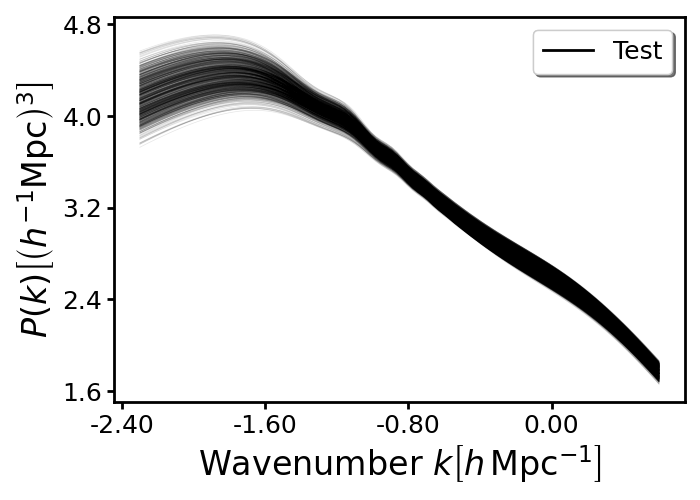

In [9]:
custom_lines = [
    mpl.lines.Line2D([0], [0], color='k', ls='-', lw=2, marker=None, markersize=9),
]

fig, ax = sbibe.plot_utils.simple_plot(
    x_label=r'Wavenumber $k \left[ h\, \mathrm{Mpc}^{-1} \right]$',
    y_label=r'$P(k) \left[ \left(h^{-1} \mathrm{Mpc}\right)^{3} \right]$',
    custom_labels=[r'Test'],
    custom_lines=custom_lines
)

tmp_xx_plot = xx_test
tmp_xx_plot = tmp_xx_plot[np.random.choice(tmp_xx_plot.shape[0], tmp_xx_plot.shape[0], replace=False)].T
ax.plot(np.log10(kk), tmp_xx_plot, c='k', alpha=0.1, lw=0.5)

plt.tight_layout()
plt.show()

## (Optional) Visualize xx associatted with inferred posteriors

Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading linear emulator...


/lscratch/dlopez/programs/miniconda_20221210/miniconda3/envs/VE_SBIBE/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/lscratch/dlopez/programs/miniconda_20221210/miniconda3/envs/VE_SBIBE/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/lscratch/dlopez/programs/miniconda_20221210/miniconda3/envs/VE_SBIBE/lib/python3.11/site-packages/sklearn/base

Linear emulator loaded in memory.
Loading no-wiggles emulator...
No-wiggles emulator loaded in memory.
Loading non-linear emulator...


/lscratch/dlopez/programs/miniconda_20221210/miniconda3/envs/VE_SBIBE/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/lscratch/dlopez/programs/miniconda_20221210/miniconda3/envs/VE_SBIBE/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.22.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/lscratch/dlopez/programs/miniconda_20221210/miniconda3/envs/VE_SBIBE/lib/python3.11/site-packa

Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.


<IPython.core.display.Javascript object>


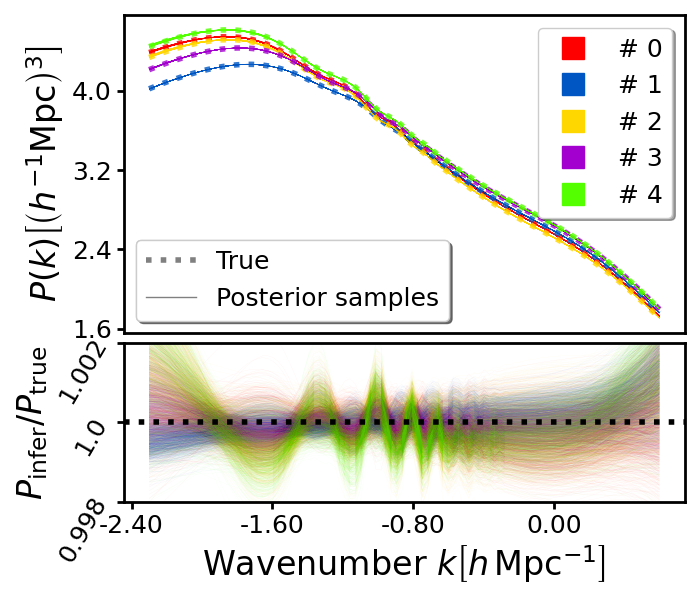

In [10]:
tmp_inferred_xx_test = sbibe.sbi_data_utils.compute_baccoemu_predictions_batch(
    inferred_theta_test[indexes],
    list(dict_bounds_test.keys())
)

fig, ax, ax_res = sbibe.plot_utils.plot_xx_from_sampled_posteriors(xx_test[indexes], tmp_inferred_xx_test, kk)
plt.show()

## Posteriors examples

<IPython.core.display.Javascript object>


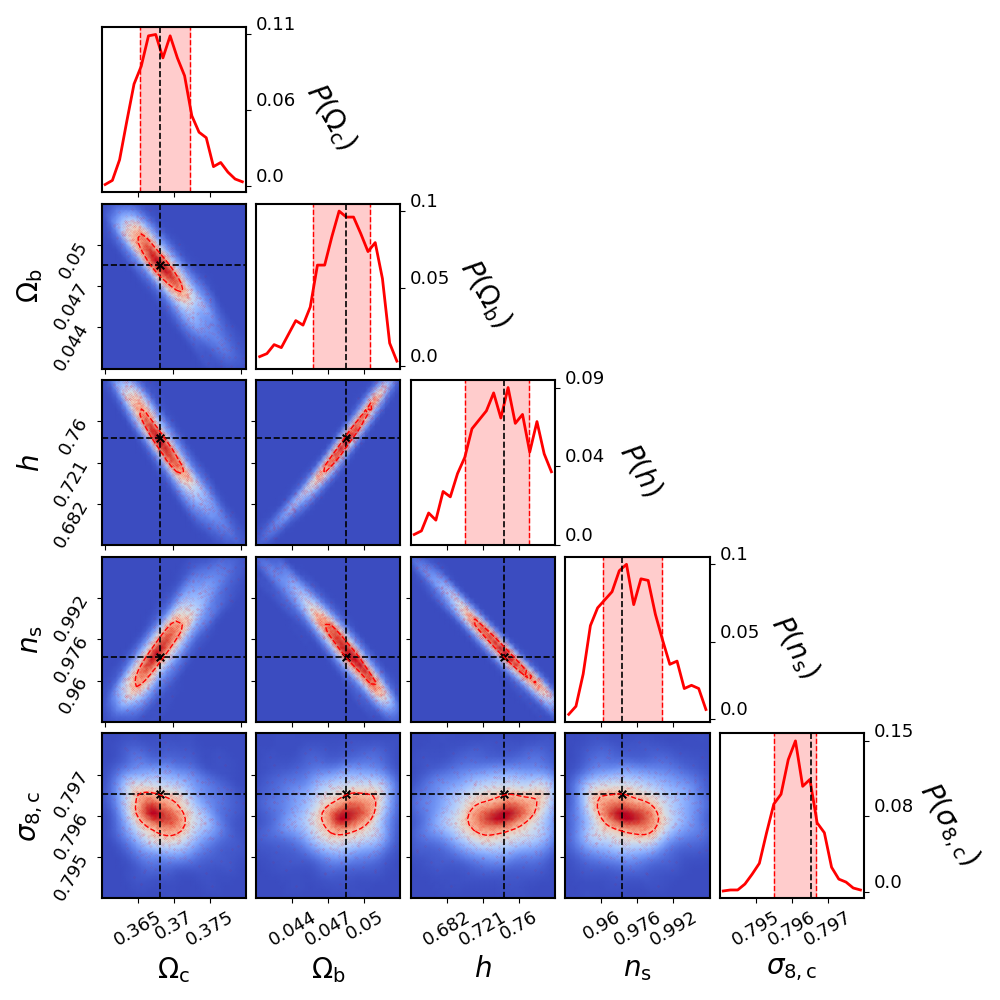

/lscratch/dlopez/Projects/SBI-baccoemu/SBIBE/plot_utils.py:213: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(tmp_xx, tmp_yy, s=.01, c=color_infer, alpha=0.5)


<IPython.core.display.Javascript object>


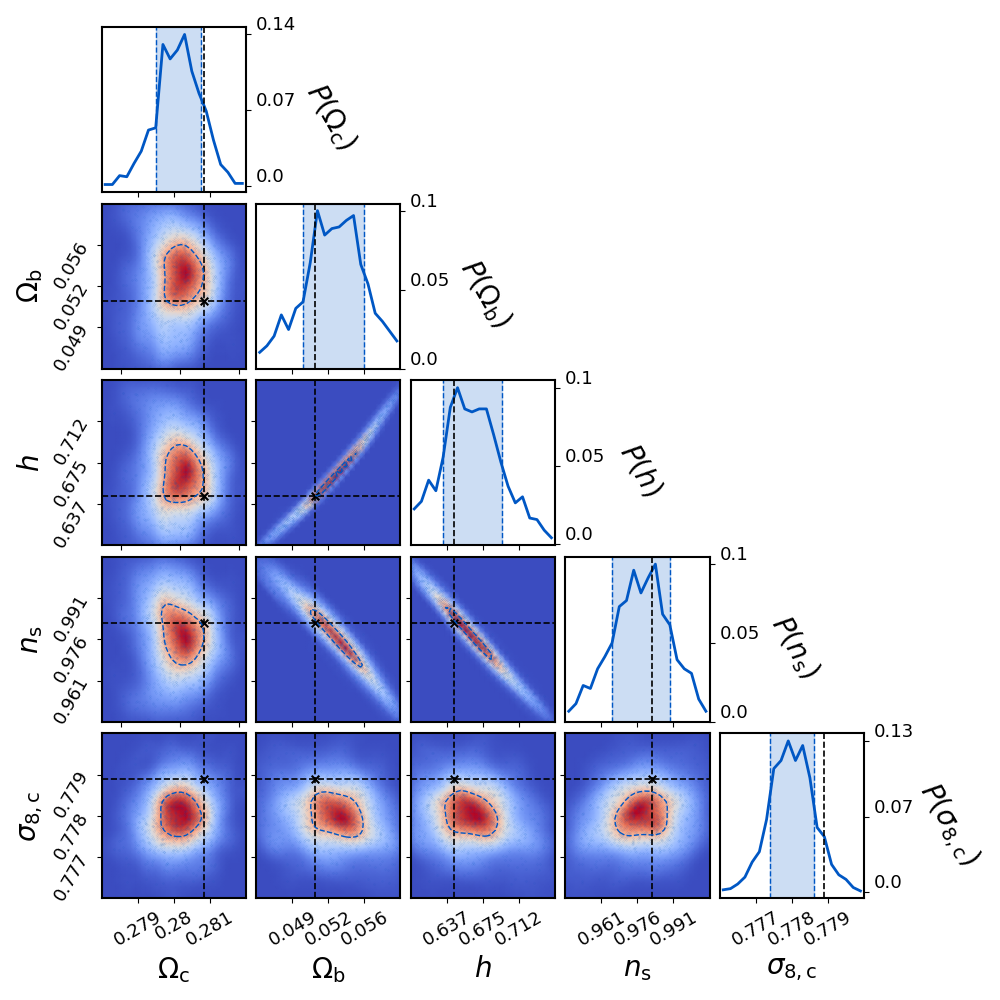

<IPython.core.display.Javascript object>


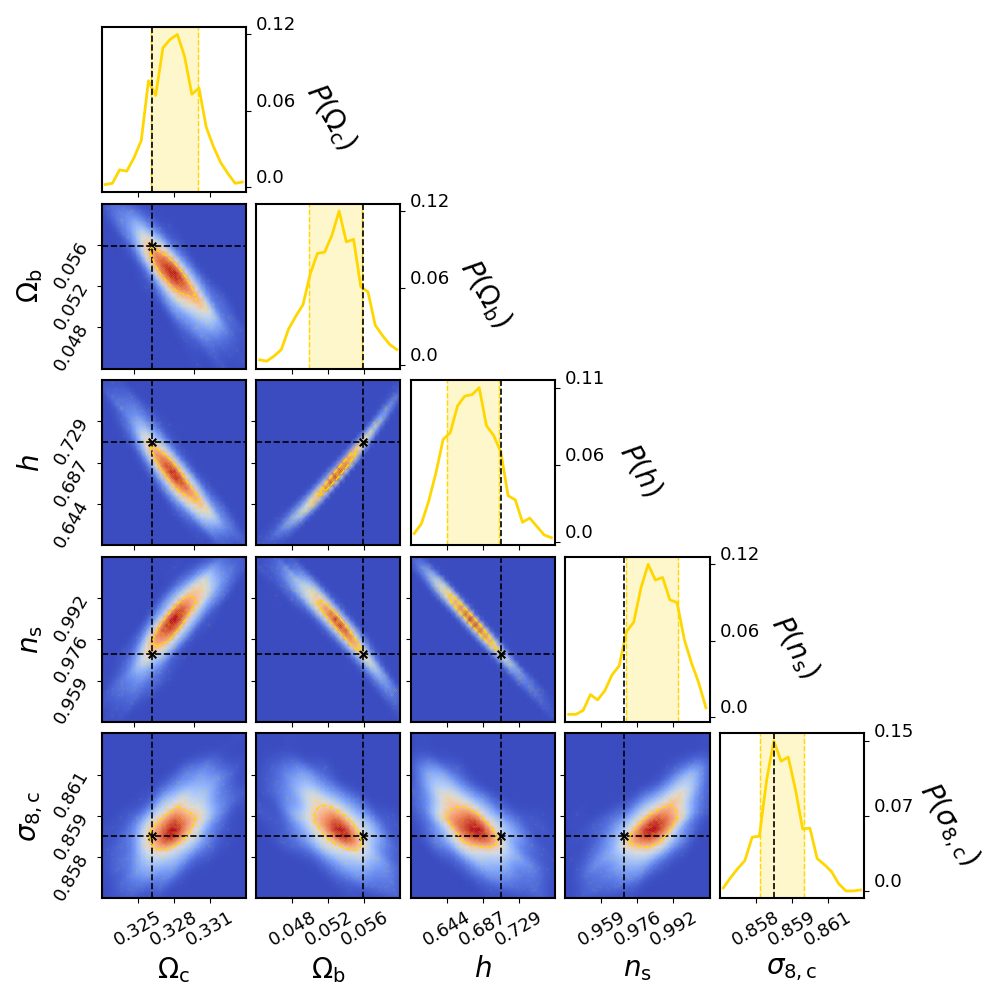

<IPython.core.display.Javascript object>


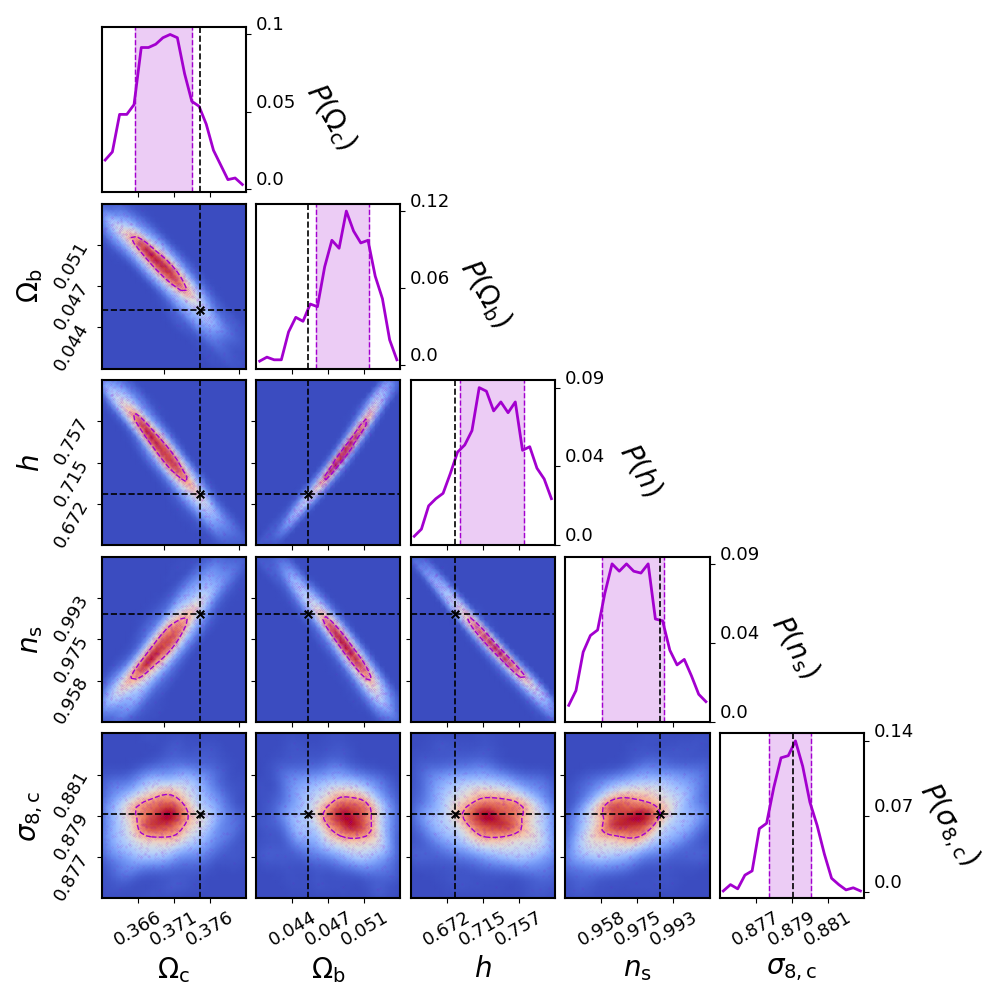

<IPython.core.display.Javascript object>


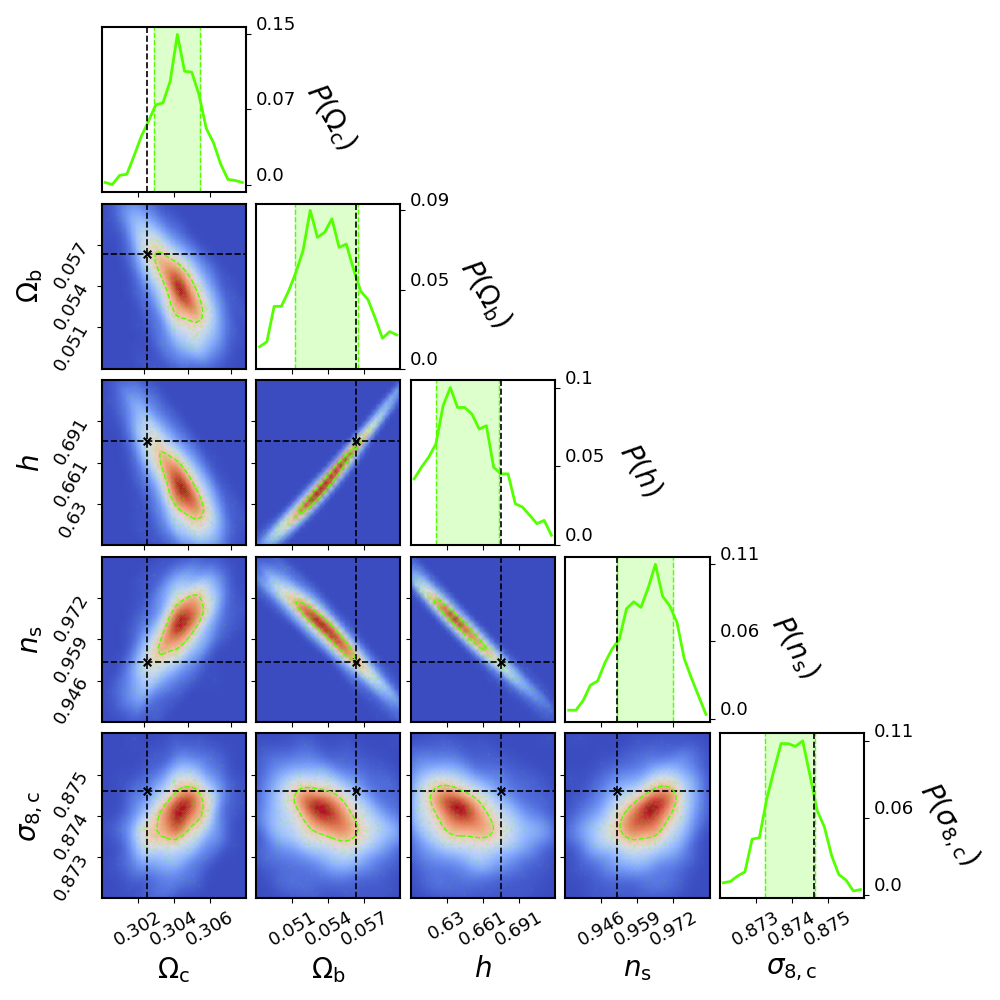

In [11]:
colors = sbibe.plot_utils.get_N_colors(N_examples, mpl.colormaps['prism'])
for ii_sample in range(N_examples):
    fig, axs = sbibe.plot_utils.corner_plot(
        theta_test[ii_sample],
        inferred_theta_test[ii_sample],
        custom_titles,
        color_infer=colors[ii_sample]
    )
    plt.show()

## Rank statistics

<IPython.core.display.Javascript object>


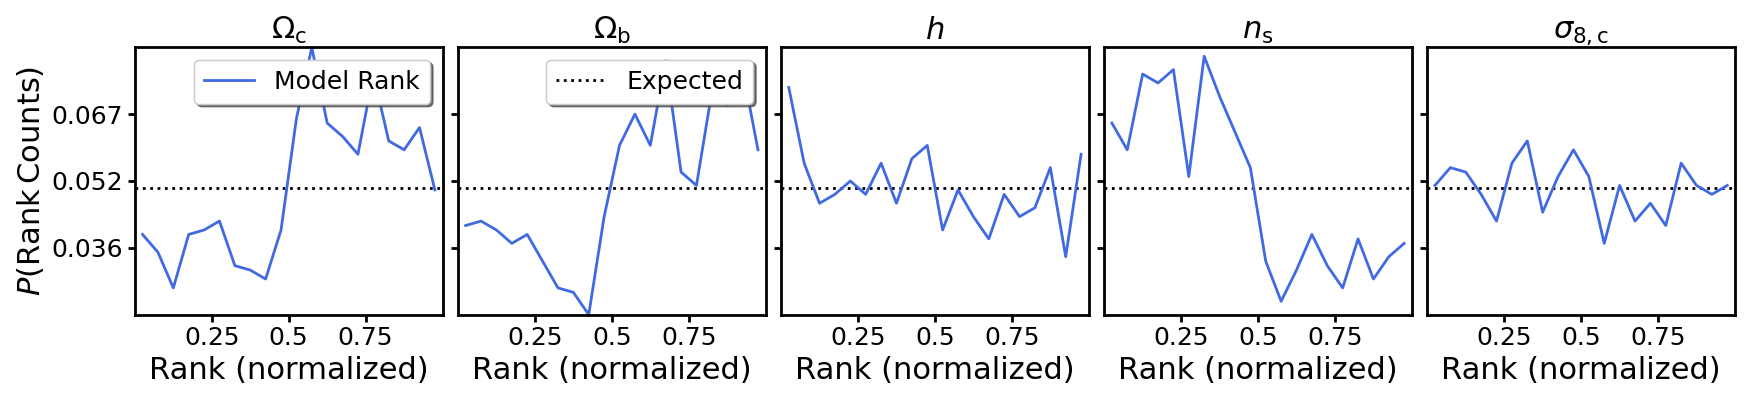

In [12]:
fig, axs = sbibe.plot_utils.plot_rank_statistcis(ranks, inferred_theta_test.shape[1], custom_titles)
plt.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.show()

## Inference errors

<IPython.core.display.Javascript object>


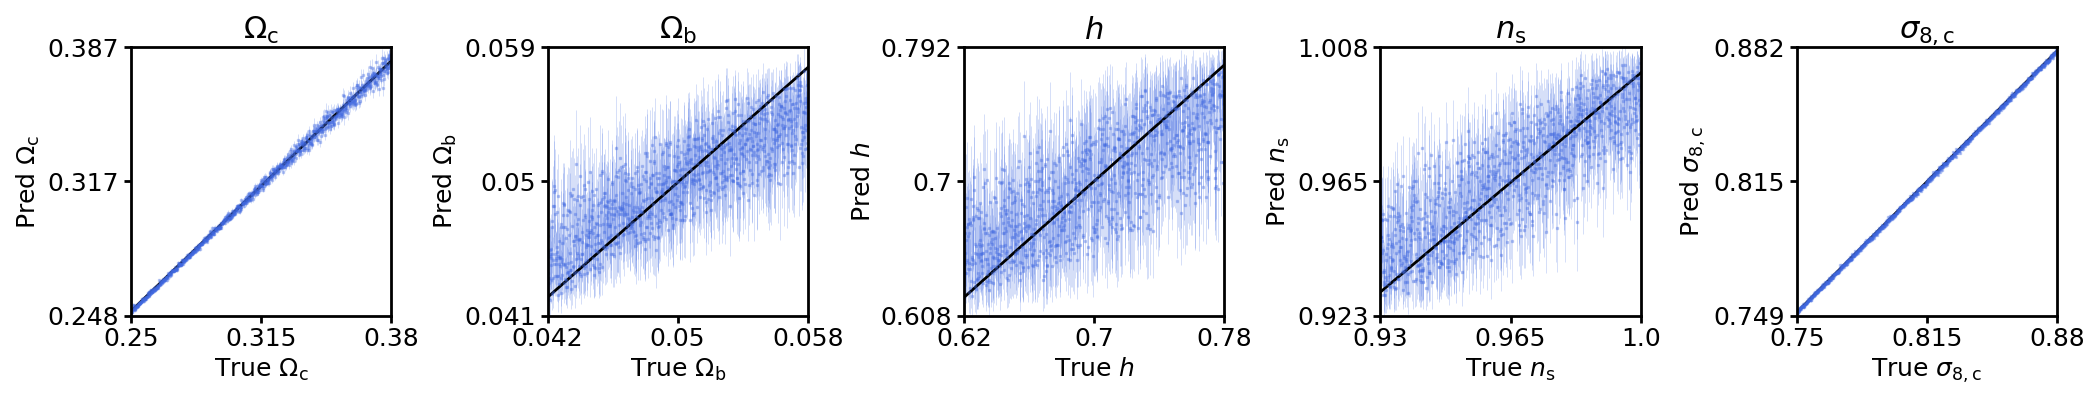

In [13]:
fig, axs = sbibe.plot_utils.plot_parameter_prediction_vs_truth(inferred_theta_test, theta_test, custom_titles)
plt.tight_layout()
plt.subplots_adjust(wspace=0.6)
plt.show()